# Double LSTM network : 
We consider both the begining and the end of the sequence, each subsequence is given to an lstm. The two lstm last output are concatenate an given to a fully connected layer

## Imports

In [1]:
import numpy as np
import time 


from pprint import pprint
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, RNN, LSTM, GRU, Conv1d
from torch.nn.functional import softmax, relu

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import random

## Cuda stuff

In [2]:
use_cuda = torch.cuda.is_available()
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

print(use_cuda)


True


# Data handling

## Reduce training datas
Evantually taking only a part of the sequences 

In [3]:
id_seqs = {str(i):[] for i in range(6)}
with open('train_filtered.txt','r') as fIn : 
    for line in fIn : 
        line = line.split(',')
        id_seqs[line[1].strip()].append(line[0])

## Upsampling
upsampling to handle classe unbalance

In [4]:
print([len(id_seqs[str(i)]) for i in range(6)])
upsampling_len = max([len(id_seqs[str(i)]) for i in range(6)])
duplication_factors = [upsampling_len//len(id_seqs[str(i)]) for i in range(6)]
id_seqs_duplicate = {str(i) : id_seqs[str(i)]*duplication_factors[i] for i in range(6)}
to_add_by_sampling = [upsampling_len - len(id_seqs_duplicate[str(i)]) for i in range(6)]
id_seqs_final = {str(i) : id_seqs_duplicate[str(i)] + random.sample(id_seqs_duplicate[str(i)],to_add_by_sampling[i]) for i in range(6)}
print([len(id_seqs_final[str(i)]) for i in range(6)])

[3486, 5531, 814, 2874, 1578, 328]
[5531, 5531, 5531, 5531, 5531, 5531]


## Reduce Dataset size 

In [5]:
def reduce_dataset(size, data_dict):
    """
        Reduce a balanced dataset to size (for each category)
    """
    return {str(i) : random.sample(data_dict[str(i)], size) for i in range(6)}

In [6]:

ids_seqs_final_reduced = reduce_dataset(3486,id_seqs_final)

## Select certain categories
We foccused our efforts on classifying categories 0 and 3. Selection of corresponding data both in training and testing files

In [7]:
TAKE_FIRST = 600
TAKE_LAST = 600

with open('train_mini.txt','w') as fOut : 
    for classif in [0,3]:
        for seq in ids_seqs_final_reduced[str(classif)]:
            fOut.write(seq[:2*TAKE_FIRST] + "," + seq[-2*TAKE_LAST:] + "," + str(classif) +"\n")


In [8]:
id_seqs = {str(i):[] for i in range(6)}
with open('test_filtered.txt','r') as fIn : 
    for line in fIn : 
        line = line.split(',')
        id_seqs[line[1].strip()].append(line[0])

with open('test_mini.txt','w') as fOut : 
    for classif in [0,3]:
        for seq in id_seqs[str(classif)]:
            fOut.write(seq[:2*TAKE_FIRST] + "," + seq[-2*TAKE_LAST:] + "," + str(classif) +"\n")

# Torchtext dataloader 

In [9]:
#Initialize the two fields: Sequence and Class
SEQ_B = data.Field(sequential=True,include_lengths=True, unk_token='N')
SEQ_E = data.Field(sequential=True,include_lengths=True, unk_token='N')
LABEL = data.Field(sequential=False, unk_token='1') # is_target = True ?


train_set, validation_set, test_set = data.TabularDataset.splits(path='',
                                                                 train='train_mini.txt',
                                                                 validation='test_mini.txt',
                                                                 test='train_mini.txt', 
                                                                 format = 'csv',
                                                                 fields=[('sequence_B', SEQ_B), ('sequence_E', SEQ_E), ('label', LABEL)])

In [10]:
print('train_set.fields:', list(train_set.fields.keys()))
print('validation_set.fields:', list(validation_set.fields.keys()))
print('test_set.fields:', list(test_set.fields.keys()))
print()
print('size of training set', len(train_set))
print('size of validation set', len(validation_set))
print()
print('content of first training sample:')
print(vars(train_set[0]))

train_set.fields: ['sequence_B', 'sequence_E', 'label']
validation_set.fields: ['sequence_B', 'sequence_E', 'label']
test_set.fields: ['sequence_B', 'sequence_E', 'label']

size of training set 6972
size of validation set 1813

content of first training sample:
{'sequence_B': ['G', 'C', 'G', 'G', 'A', 'A', 'G', 'T', 'G', 'G', 'C', 'G', 'C', 'G', 'C', 'A', 'G', 'G', 'G', 'T', 'C', 'C', 'G', 'G', 'C', 'G', 'T', 'G', 'T', 'G', 'A', 'A', 'G', 'A', 'C', 'C', 'T', 'T', 'C', 'C', 'G', 'G', 'G', 'G', 'A', 'G', 'G', 'T', 'G', 'G', 'C', 'G', 'G', 'C', 'C', 'G', 'A', 'G', 'G', 'C', 'G', 'G', 'C', 'C', 'G', 'T', 'C', 'G', 'C', 'G', 'G', 'G', 'A', 'G', 'C', 'A', 'G', 'A', 'C', 'C', 'C', 'G', 'G', 'A', 'G', 'G', 'C', 'G', 'G', 'A', 'G', 'A', 'C', 'G', 'G', 'A', 'G', 'A', 'C', 'C', 'G', 'A', 'G', 'G', 'A', 'G', 'G', 'T', 'G', 'A', 'C', 'A', 'G', 'C', 'G', 'G', 'C', 'G', 'G', 'A', 'G', 'C', 'T', 'G', 'G', 'G', 'A', 'G', 'G', 'C', 'C', 'C', 'A', 'G', 'C', 'C', 'A', 'G', 'C', 'A', 'G', 'A', 'A', 'G', 'A

In [11]:
# build the vocabularies
SEQ_E.build_vocab(train_set) #NO unknows 
SEQ_B.build_vocab(train_set)
LABEL.build_vocab(train_set)

In [12]:
print('Text fields <E>:')
print(' size of vocabulary:', len(SEQ_E.vocab))
# print(" vocabulary's embedding dimension:", SEQ.vocab.vectors.size())
print(' no. times the "N" appear in the dataset:', SEQ_E.vocab.freqs['N'])
print(" list of vocabulary (int-to-str):", SEQ_E.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(SEQ_E.vocab.stoi))
print(SEQ_E.vocab.freqs)


print('Text fields <B>:')
print(' size of vocabulary:', len(SEQ_B.vocab))
# print(" vocabulary's embedding dimension:", SEQ.vocab.vectors.size())
print(' no. times the "N" appear in the dataset:', SEQ_B.vocab.freqs['N'])
print(" list of vocabulary (int-to-str):", SEQ_B.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(SEQ_B.vocab.stoi))
print(SEQ_B.vocab.freqs)

print('\nLabel fields:')
#print('keys of LABEL.vocab:', list(LABEL.vocab.__dict__.keys()))
print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))
print(LABEL.vocab.freqs)

Text fields <E>:
 size of vocabulary: 6
 no. times the "N" appear in the dataset: 0
 list of vocabulary (int-to-str): ['N', '<pad>', 'A', 'T', 'G', 'C']
 list of vocabulary (str-to-int): {'N': 0, '<pad>': 1, 'A': 2, 'T': 3, 'G': 4, 'C': 5}
Counter({'A': 1203627, 'T': 1202297, 'G': 901756, 'C': 869296})
Text fields <B>:
 size of vocabulary: 6
 no. times the "N" appear in the dataset: 0
 list of vocabulary (int-to-str): ['N', '<pad>', 'G', 'C', 'A', 'T']
 list of vocabulary (str-to-int): {'N': 0, '<pad>': 1, 'G': 2, 'C': 3, 'A': 4, 'T': 5}
Counter({'G': 1223301, 'C': 1131385, 'A': 958217, 'T': 864073})

Label fields:
 list of vocabulary (int-to-str): ['1', '0', '3']
 list of vocabulary (str-to-int): {'1': 0, '0': 1, '3': 2}
Counter({'0': 3486, '3': 3486})


In [13]:
BATCH_SIZE = 90

train_iter = data.BucketIterator(train_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence_E), #Sorting within the batch
                                 sort = True,
                                 repeat = False
                                )

validation_iter = data.BucketIterator(validation_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence_E), #Sorting within the batch
                                sort = True,
                                repeat = False
                                )


# Network

In [14]:
import sys
# size of embeddings
EMBEDDING_DIM = 100
NUM_EMBEDDING = len(SEQ_E.vocab) #size of vocab 
NUM_CLASSES = len(LABEL.vocab.itos)
HIDDEN_DIM_B = 111
HIDDEN_DIM_A = 111
HIDDEN_DIM_TOTAL = HIDDEN_DIM_B + HIDDEN_DIM_A
NUM_LAYERS_LSTM = 1


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        #learn a new embedding
        self.embeddings = nn.Embedding(NUM_EMBEDDING, EMBEDDING_DIM)

        # use pretrained embeddings
        
        self.conv1 = Conv1d(in_channels= EMBEDDING_DIM,
                            out_channels= EMBEDDING_DIM ,
                            kernel_size=3,
                            stride=3)
        
        self.lstm_begining = LSTM(input_size=EMBEDDING_DIM,
                         hidden_size=HIDDEN_DIM_B,
                         num_layers=NUM_LAYERS_LSTM,
                         bidirectional=False)
        
        self.lstm_end = LSTM(input_size=EMBEDDING_DIM,
                         hidden_size=HIDDEN_DIM_A,
                         num_layers=NUM_LAYERS_LSTM,
                         bidirectional=False)
        
        # link hidden to tag 
        self.hidden2tag = Linear(in_features=int(HIDDEN_DIM_TOTAL),
                            out_features=NUM_CLASSES,
                            bias=False)
        
        
        #init lstm hidden units 
#         self.hidden = self.init_hidden(BATCH_SIZE)

    def forward_split(self,x,is_begin = True): 
            
            seqs = x[0]
            lengths = x[1]
            
            #Embedding
            embeds = self.embeddings(seqs)
            
            #Convolution
            embeds = embeds.permute([1,2,0])
            embeds = self.conv1(embeds)
            embeds = embeds.permute([2,0,1])
            
            #LSTM
            embeds = nn.utils.rnn.pack_padded_sequence(embeds,lengths/3, batch_first=False)
            # rnn returns output and last hidden state
            if is_begin : 
                lstm_out, self.hidden_B = self.lstm_begining(embeds)
            else : 
                lstm_out, self.hidden_E = self.lstm_end(embeds)
                
            unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=False)
            last_output = unpacked[-1].type(torch.float)
            
            return(last_output)
        
    def forward(self, x):
        
        #x = {"B": [seq,length], "E": [seq,length]}

            
        x_B = x["B"]
        x_E = x["E"]
        
        last_output_B = self.forward_split(x_B)
        last_output_E = self.forward_split(x_E, is_begin = False)
        
        last_output = torch.cat([last_output_B, last_output_E], 1)
        
        
        tag_space = self.hidden2tag(last_output)
        tag_scores = softmax(tag_space)
        return tag_scores

    


net = Net()
if use_cuda:
    net.cuda()
    print("using cuda")
print(net)

using cuda
Net(
  (embeddings): Embedding(6, 100)
  (conv1): Conv1d(100, 100, kernel_size=(3,), stride=(3,))
  (lstm_begining): LSTM(100, 111)
  (lstm_end): LSTM(100, 111)
  (hidden2tag): Linear(in_features=222, out_features=3, bias=False)
)


In [15]:
# check which params require grad
{p[0]: p[1].requires_grad for p in net.named_parameters()}

{'embeddings.weight': True,
 'conv1.weight': True,
 'conv1.bias': True,
 'lstm_begining.weight_ih_l0': True,
 'lstm_begining.weight_hh_l0': True,
 'lstm_begining.bias_ih_l0': True,
 'lstm_begining.bias_hh_l0': True,
 'lstm_end.weight_ih_l0': True,
 'lstm_end.weight_hh_l0': True,
 'lstm_end.bias_ih_l0': True,
 'lstm_end.bias_hh_l0': True,
 'hidden2tag.weight': True}

In [16]:
criterion = nn.CrossEntropyLoss() #weight = final_weights
# we filter the model's parameters such that we can remove the embedding layer, 
# which does not have requires_grad
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
#     print(torch.max(ys, 1)[1], ts)
#     print(correct_prediction)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

def construct_sentences(batch):
    return [" ".join([SEQ.vocab.itos[elm] 
                      for elm in get_numpy(batch.sequence[:,i])])
            for i in range(batch.sequence.size()[1])]

def get_labels(batch):
    return [LABEL.vocab.itos[get_numpy(batch.label[i])] for i in range(len(batch.label))]

In [17]:
num_epoch = 40
iter_by_epoch = int(len(train_set)/BATCH_SIZE)
eval_every = 100

reduced_train_lost = []
reduced_train_accuracy = []

reduced_val_lost = []
reduced_val_accuracy = []

train_loss, train_accs = [], []
val_loss, val_accs = [], []

epoch_index = []
times = []
i = 0


for epoch in range(num_epoch):
    
    train_loss, train_accs = [], []
    val_loss, val_accs = [], []
    
    net.train()
    # Training
    for i, batch in enumerate(train_iter):
            
        optimizer.zero_grad()
        feed_network = {"B":batch.sequence_B, "E":batch.sequence_E}
        output = net(feed_network)
        batch_loss = criterion(output, batch.label)

        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output, batch.label)))


        if i % eval_every == 0:     
            net.eval()
            val_losses_running, val_accs_running, val_lengths = 0, 0, 0
            
            for val_batch in validation_iter:
                feed_network = {"B":val_batch.sequence_B, "E":val_batch.sequence_E}
                output = net(feed_network)
                val_losses_running += criterion(output, val_batch.label)*val_batch.batch_size
                val_accs_running += accuracy(output, val_batch.label) *val_batch.batch_size
                val_lengths += val_batch.batch_size

            # divide by the total accumulated batch sizes
            val_losses_running /= val_lengths
            val_accs_running /= val_lengths
            val_loss.append(get_numpy(val_losses_running))
            val_accs.append(get_numpy(val_accs_running))
            net.train()
        
        batch_loss.backward()     
        optimizer.step()
        
        i += 1
    
    reduced_train_lost.append(np.mean(train_loss))
    reduced_train_accuracy.append(np.mean(train_accs))
    
    reduced_val_lost.append(np.mean(val_loss))
    reduced_val_accuracy.append(np.mean(val_accs))
    
    epoch_index.append(epoch)
    times.append(time.time())
    
    print(f'Epoch {epoch}\tTrain {np.mean(train_loss):.3f}\tVal {np.mean(val_loss):.3f}')
    
# 500, 20, 100/

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0	Train 1.128	Val 1.107


KeyboardInterrupt: 

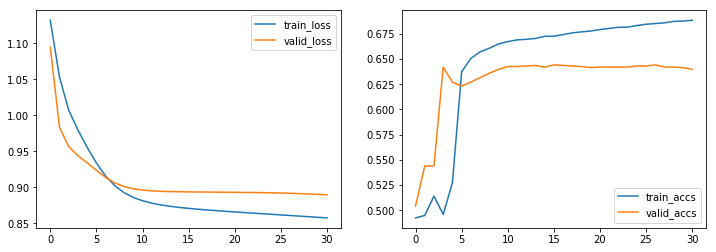

ValueError: fname must be a PathLike or file handle

<Figure size 432x288 with 0 Axes>

In [22]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(epoch_index,reduced_train_lost,label='train_loss')
plt.plot(epoch_index,reduced_val_lost, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_index, reduced_train_accuracy, label='train_accs')
plt.plot(epoch_index, reduced_val_accuracy, label='valid_accs')
plt.legend()
plt.show()
plt.savefig(fig, format="svg")


In [ ]:
## eventually store data in files 

with open("train_loss",'w') as fOut :
    for i,j in zip(train_iter_index,reduced_train_lost) : 
        fOut.write(str(i)+"," + str(j)+"\n")

with open("valid_loss",'w') as fOut :
    for i,j in zip(valid_iter_index, valid_loss) : 
        fOut.write(str(i)+"," + str(j)+"\n")
        
with open("train_acc",'w') as fOut :
    for i,j in zip(train_iter_index, reduced_train_accuracy) : 
        fOut.write(str(i)+"," + str(j)+"\n")
        
with open("val_acc",'w') as fOut :
    for i,j in zip(train_iter_index,reduced_train_lost) : 
        fOut.write(str(i)+"," + str(j)+"\n")



# Result analysis

In [18]:
net.eval()
val_losses, val_accs, val_lengths = 0, 0, 0
predictions = []
real_values = []
for val_batch in validation_iter:
    feed_network = {"B":val_batch.sequence_B, "E":val_batch.sequence_E}
    output = net(feed_network)
    predictions += [ LABEL.vocab.itos[int(i)] for i in torch.max(output,1)[1]]
    real_values += [LABEL.vocab.itos[int(i)] for i in val_batch.label]
    val_losses += criterion(output, val_batch.label)*val_batch.batch_size
    print(accuracy(output, val_batch.label) *val_batch.batch_size, val_batch.batch_size)
    val_accs += accuracy(output, val_batch.label) *val_batch.batch_size
    val_lengths += val_batch.batch_size

# divide by the total accumulated batch sizes
val_losses /= val_lengths
val_accs /= val_lengths
valid_loss.append(get_numpy(val_losses))
valid_accs.append(get_numpy(val_accs))
net.train()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(67.0000, device='cuda:0') 90
tensor(90., device='cuda:0') 90
tensor(90., device='cuda:0') 90
tensor(90., device='cuda:0') 90
tensor(90., device='cuda:0') 90
tensor(90., device='cuda:0') 90
tensor(90., device='cuda:0') 90
tensor(90., device='cuda:0') 90
tensor(90., device='cuda:0') 90


RuntimeError: CUDA out of memory. Tried to allocate 20.62 MiB (GPU 0; 11.17 GiB total capacity; 2.10 GiB already allocated; 18.31 MiB free; 342.98 MiB cached)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

In [20]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [21]:
#Stupid modification to get order in confusion matrix
predictions = [i if i!='1' else '400' for i in predictions]

In [22]:
cnf_matrix = confusion_matrix(real_values, predictions)
np.set_printoptions(precision=2)

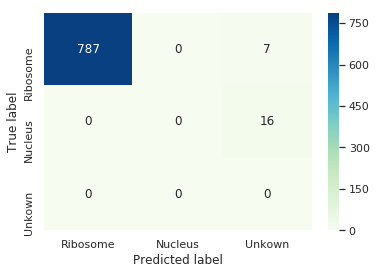

In [23]:
import seaborn as sns; sns.set()
ax = plt.axes()

sns.heatmap(cnf_matrix,annot=True, cmap= "GnBu",fmt="d", xticklabels = ["Ribosome", "Nucleus", "Unkown"], yticklabels = ["Ribosome", "Nucleus", "Unkown"])
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.savefig("double_lstm_confusion.png")
plt.show()

In [24]:

cnf_matrix = np.array([[521,465,7],[160,644,16],[0,0,0]])
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("By class accuracies :\n")
print(cm.diagonal())

print("total accuracy :\n")
print(accuracy_score(real_values, predictions))

By class accuracies :

[0.52 0.79  nan]
total accuracy :

0.971604938271605


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
